# Elo Merchant Category Recommendation - Feature engineering
End date: _2019. february 19._<br/>

This tutorial notebook is part of a series for [Elo Mechant Category Recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation) contest organized by Elo, one of the largest payment brands in Brazil. It has built partnerships with merchants in order to offer promotions or discounts to cardholders. The objective of the competition is to identify and serve the most relevant opportunities to individuals, by uncovering signals in customer loyalty. LynxKite does not yet support some of the data preprocessing, thus they need to be done in Python. The input files are available from the [download](https://www.kaggle.com/c/elo-merchant-category-recommendation/data) section of the contest:

- **train.csv**,  **test.csv**: list of `card_ids` that can be used for training and testing
- **historical_transactions.csv**: contains up to 3 months' worth of transactions for every card at any of the provided `merchant_ids`
- **new_merchant_transactions.csv**: contains the transactions at new merchants (`merchant_ids` that this particular `card_id` 
has not yet visited) over a period of two months
- **merchants.csv**: contains aggregate information for each `merchant_id` represented in the data set

In [76]:
import gc
import time
import warnings
import datetime
import calendar
import numpy as np
import pandas as pd
#import seaborn as sns
import lightgbm as lgb
from datetime import date
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
import matplotlib.gridspec as gridspec
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, RepeatedKFold

%matplotlib inline
warnings.simplefilter('ignore', UserWarning)
gc.enable()

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
def create_date_features(df, source_column, preposition):
    df[preposition + '_date'] = pd.to_datetime(df[source_column])
    df[preposition + '_year'] = df[source_column].dt.year
    df[preposition + '_quarter'] = df[source_column].dt.quarter
    df[preposition + '_month'] = df[source_column].dt.month
    df[preposition + '_month_start'] = df[source_column].dt.is_month_start
    df[preposition + '_weekofyear'] = df[source_column].dt.weekofyear
    df[preposition + '_weekend'] = (df[source_column].dt.weekday >=5).astype(int)
    df[preposition + '_dayofweek'] = df[source_column].dt.dayofweek
    df[preposition + '_day'] = df[source_column].dt.day
    df[preposition + '_hour'] = df[source_column].dt.hour

    return df

## Input data preparation
https://www.kaggle.com/roydatascience/elo-stack-with-goss-boosting
https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/75034
### Transactions
#### Load

In [ ]:
df_new_trans = pd.read_csv("preprocessed/trans_merch_new_agg.csv")
df_new_trans = reduce_mem_usage(df_new_trans)

df_hist_trans = pd.read_csv("preprocessed/trans_merch_hist_agg.csv")
df_hist_trans = reduce_mem_usage(df_hist_trans)

In [ ]:
df_hist_trans.drop(['Unnamed: 0'], inplace=True, axis=1)
df_new_trans.drop(['Unnamed: 0'], inplace=True, axis=1)

#### Preparation

In [4]:
%%time
df_hist_trans = pd.read_csv("input/historical_transactions.csv")
df_hist_trans = reduce_mem_usage(df_hist_trans)
print('Number of historical transactions: {:,}'.format(len(df_hist_trans)))

Starting memory usage: 3109.54 MB
Reduced memory usage: 1749.11 MB (43.7% reduction)
Number of historical transactions: 29,112,361
CPU times: user 1min 34s, sys: 1min 20s, total: 2min 54s
Wall time: 3min 50s


In [5]:
%%time
df_new_trans = pd.read_csv("input/new_merchant_transactions.csv")
df_new_trans = reduce_mem_usage(df_new_trans)
print('Number of new transactions: {:,}'.format(len(df_new_trans)))

Starting memory usage: 209.67 MB
Reduced memory usage: 114.20 MB (45.5% reduction)
Number of new transactions: 1,963,031
CPU times: user 7.38 s, sys: 1.41 s, total: 8.78 s
Wall time: 9.88 s


In [6]:
df_hist_trans['authorized_flag'] = df_hist_trans['authorized_flag'].map({'Y': 1, 'N': 0})
df_hist_trans['category_1'] = df_hist_trans['category_1'].map({'N': 0, 'Y': 1})
df_hist_trans['category_2'] = pd.to_numeric(df_hist_trans['category_2'])
df_hist_trans['category_3'] = df_hist_trans['category_3'].map({'A': 0, 'B': 1, 'C': 2})

df_hist_trans['purchase_date'] = pd.to_datetime(df_hist_trans['purchase_date'])
df_hist_trans = create_date_features(df_hist_trans, 'purchase_date', 'purchase')

In [7]:
df_new_trans['authorized_flag'] = df_new_trans['authorized_flag'].map({'Y': 1, 'N': 0})
df_new_trans['category_1'] = df_new_trans['category_1'].map({'N': 0, 'Y': 1})
df_new_trans['category_2'] = pd.to_numeric(df_new_trans['category_2'])
df_new_trans['category_3'] = df_new_trans['category_3'].map({'A': 0, 'B': 1, 'C': 2})

df_new_trans['purchase_date'] = pd.to_datetime(df_new_trans['purchase_date'])
df_new_trans = create_date_features(df_new_trans, 'purchase_date', 'purchase')

In [8]:
def get_time_of_month(day_of_month):
    if day_of_month < 10:
        time_of_month = 0 # Beginning
    elif day_of_month >= 10 and day_of_month < 20:
        time_of_month = 1 # Middle
    else:
        time_of_month = 2 # End
    return time_of_month

In [9]:
df_hist_trans['purchase_part_of_month'] = df_hist_trans['purchase_day'].apply(lambda x: get_time_of_month(x))

In [10]:
df_new_trans['purchase_part_of_month'] = df_new_trans['purchase_day'].apply(lambda x: get_time_of_month(x))

In [11]:
df_new_trans[:3]

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,...,purchase_year,purchase_quarter,purchase_month,purchase_month_start,purchase_weekofyear,purchase_weekend,purchase_dayofweek,purchase_day,purchase_hour,purchase_part_of_month
0,1,C_ID_415bb3a509,107,0,1,1.0,307,M_ID_b0c793002c,1,-0.557617,...,2018,1,3,False,10,1,6,11,14,1
1,1,C_ID_415bb3a509,140,0,1,1.0,307,M_ID_88920c89e8,1,-0.569336,...,2018,1,3,False,12,0,0,19,18,1
2,1,C_ID_415bb3a509,330,0,1,1.0,507,M_ID_ad5237ef6b,2,-0.551270,...,2018,2,4,False,17,0,3,26,14,2


In [12]:
df_hist_trans[:3]

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,...,purchase_year,purchase_quarter,purchase_month,purchase_month_start,purchase_weekofyear,purchase_weekend,purchase_dayofweek,purchase_day,purchase_hour,purchase_part_of_month
0,1,C_ID_4e6213e9bc,88,0,0,0.0,80,M_ID_e020e9b302,-8,-0.703331,...,2017,2,6,False,25,1,6,25,15,2
1,1,C_ID_4e6213e9bc,88,0,0,0.0,367,M_ID_86ec983688,-7,-0.733128,...,2017,3,7,False,28,1,5,15,12,1
2,1,C_ID_4e6213e9bc,88,0,0,0.0,80,M_ID_979ed661fc,-6,-0.720386,...,2017,3,8,False,32,0,2,9,22,0


##### Calculating the number of transactions

In [13]:
df_hist_gb_card_id = df_hist_trans.groupby("card_id").size().reset_index().set_index('card_id').sort_index(axis=1).rename({0:'number_of_transactions'}, axis=1)

In [14]:
df_hist_gb_card_id[:3]

,number_of_transactions
card_id,
C_ID_00007093c1,149
C_ID_0001238066,123
C_ID_0001506ef0,66


In [15]:
df_hist_gb_merchant_id = df_hist_trans.groupby("merchant_id").size().reset_index().set_index('merchant_id').sort_index(axis=1).rename({0:'number_of_transactions'}, axis=1)

In [16]:
df_hist_gb_merchant_id[:3]

,number_of_transactions
merchant_id,
M_ID_000025127f,9
M_ID_0000699140,57
M_ID_00006a5552,1


##### Aggregation

In [23]:
df_hist_trans = pd.merge(df_hist_trans, df_merch, on='merchant_id', how='left', suffixes=['_trans','_merch'])

In [24]:
df_new_trans = pd.merge(df_new_trans, df_merch, on='merchant_id', how='left', suffixes=['_trans','_merch'])

In [25]:
def aggregate_transactions(df, prefix):  
    agg_funcs = {
        'authorized_flag': ['sum', 'mean'],
        'active_months_lag3': ['sum', 'mean'],
        'active_months_lag6': ['sum', 'mean'],
        'active_months_lag12': ['sum', 'mean'],
        
        'avg_sales_lag3': ['sum', 'mean'],
        'avg_sales_lag6': ['sum', 'mean'], 
        'avg_sales_lag12': ['sum', 'mean'],
        
        'avg_purchases_lag3': ['sum', 'mean'], 
        'avg_purchases_lag6': ['sum', 'mean'], 
        'avg_purchases_lag12': ['sum', 'mean'], 

        'card_id': ['size'],
        'category_1_trans': ['sum', 'mean'],
        'category_1_merch': ['sum', 'mean'],
        'category_2_trans': ['sum', 'mean'],
        'category_2_merch': ['sum', 'mean'],
        'category_3': ['sum', 'mean'],
        'category_4': ['sum', 'mean'], 
        
        'city_id_trans': ['nunique'],
        'city_id_merch': ['nunique'],
        
        'installments': ['sum', 'median', 'mean', 'max', 'min', 'std'],

        'merchant_id': ['nunique'],
        'merchant_category_id_trans': ['nunique'],
        'merchant_category_id_merch': ['nunique'],
        'merchant_group_id': ['nunique'],
        'month_lag': ['max', 'min', 'mean', 'var'],
        
        'most_recent_sales_range': ['sum', 'mean', 'max', 'min', 'std'],
        'most_recent_purchases_range': ['sum', 'mean', 'max', 'min', 'std'],
        
        'numerical_1': ['mean', 'median', 'max', 'min', 'std'],
        'numerical_2': ['mean', 'median', 'max', 'min', 'std'],
        'number_of_transactions': ['mean', 'median', 'max', 'min', 'std'],

        'state_id_trans': ['nunique'],
        'state_id_merch': ['nunique'],
        'subsector_id_trans': ['nunique'],
        'subsector_id_merch': ['nunique'],
        
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_year': ['mean', 'median', 'max', 'min', 'std', 'nunique'],
        'purchase_month': ['mean', 'median', 'max', 'min', 'std', 'nunique'],
        'purchase_day': ['mean', 'median', 'max', 'min', 'std', 'nunique'],
        'purchase_hour': ['mean', 'median', 'max', 'min', 'std', 'nunique'],
        'purchase_weekofyear': ['mean', 'median', 'max', 'min', 'std', 'nunique'],
        'purchase_dayofweek': ['mean', 'median', 'max', 'min', 'std', 'nunique'],
        'purchase_quarter': ['mean', 'median', 'max', 'min', 'std'],
        'purchase_part_of_month': ['mean', 'median'],
        
        'purchase_weekend': ['sum', 'mean']
    }
    df_agg = df.groupby('card_id').agg(agg_funcs)
    df_agg.columns = [prefix + '_'.join(col).strip() for col in df_agg.columns.values]
    df_agg.reset_index(inplace=True)

    df = (df_agg.groupby('card_id').size().reset_index(name='{}transactions_count'.format(prefix)))
    df_agg = pd.merge(df, df_agg, on='card_id', how='left')

    return df_agg

In [26]:
%%time
df_new_trans = aggregate_transactions(df_new_trans, prefix='new_')

CPU times: user 38.2 s, sys: 13.8 s, total: 52 s
Wall time: 54.3 s


In [27]:
df_new_trans.to_csv('preprocessed/trans_merch_new_agg.csv')

In [28]:
df_hist_trans = reduce_mem_usage(df_hist_trans)

Starting memory usage: 8884.39 MB
Reduced memory usage: 3720.34 MB (58.1% reduction)


In [29]:
%%time
df_hist_trans = aggregate_transactions(df_hist_trans, prefix='hist_')

CPU times: user 6min 51s, sys: 46.4 s, total: 7min 38s
Wall time: 8min 13s


In [30]:
df_hist_trans.to_csv('preprocessed/trans_merch_hist_agg.csv')

### Train and test data
#### Load

In [ ]:
df_train = pd.read_csv("preprocessed/train_parsed.csv", index_col="card_id")
df_test = pd.read_csv("preprocessed/test_parsed.csv", index_col="card_id")

#### Preparation

In [31]:
df_train = pd.read_csv("input/train.csv", parse_dates=["first_active_month"], index_col="card_id")
df_train = reduce_mem_usage(df_train)
print("{:,} observations and {} features in train set.".format(df_train.shape[0], df_train.shape[1]))

Starting memory usage:  9.24 MB
Reduced memory usage:  4.04 MB (56.2% reduction)
201,917 observations and 5 features in train set.


In [32]:
df_test = pd.read_csv("input/test.csv", parse_dates=["first_active_month"], index_col="card_id")
df_test = reduce_mem_usage(df_test)
print("{:,} observations and {} features in test set.".format(df_test.shape[0], df_test.shape[1]))

Starting memory usage:  4.72 MB
Reduced memory usage:  2.24 MB (52.5% reduction)
123,623 observations and 4 features in test set.


In [33]:
df_train['elapsed_days'] = (np.datetime64('2018-02-01') - df_train['first_active_month'].values.astype('datetime64[D]')).astype(np.int64)
df_test['elapsed_days'] = (np.datetime64('2018-02-01') - df_test['first_active_month'].values.astype('datetime64[D]')).astype(np.int64)

In [34]:
df_train[:3]

,first_active_month,feature_1,feature_2,feature_3,target,elapsed_days
card_id,,,,,,
C_ID_92a2005557,2017-06-01,5,2,1,-0.820312,245
C_ID_3d0044924f,2017-01-01,4,1,0,0.392822,396
C_ID_d639edf6cd,2016-08-01,2,2,0,0.687988,549


In [35]:
df_test[:3]

,first_active_month,feature_1,feature_2,feature_3,elapsed_days
card_id,,,,,
C_ID_0ab67a22ab,2017-04-01,3,3,1,306
C_ID_130fd0cbdd,2017-01-01,2,3,0,396
C_ID_b709037bc5,2017-08-01,5,1,1,184


In [36]:
df_train["year"] = df_train["first_active_month"].dt.year
df_train["month"] = df_train["first_active_month"].dt.month

df_train['days_feature1'] = df_train['elapsed_days'] * df_train['feature_1']
df_train['days_feature2'] = df_train['elapsed_days'] * df_train['feature_2']
df_train['days_feature3'] = df_train['elapsed_days'] * df_train['feature_3']

In [37]:
df_test["year"] = df_test["first_active_month"].dt.year
df_test["month"] = df_test["first_active_month"].dt.month

df_test['days_feature1'] = df_test['elapsed_days'] * df_test['feature_1']
df_test['days_feature2'] = df_test['elapsed_days'] * df_test['feature_2']
df_test['days_feature3'] = df_test['elapsed_days'] * df_test['feature_3']

In [39]:
df_train = pd.merge(df_train, df_hist_gb_card_id, left_index=True, right_index=True, how='left')
df_test = pd.merge(df_test, df_hist_gb_card_id, left_index=True, right_index=True, how='left')

In [43]:
df_train.to_csv('preprocessed/train_parsed.csv')
df_test.to_csv('preprocessed/test_parsed.csv')

### Merchants

#### Preparation

In [18]:
df_merch = pd.read_csv("input/merchants.csv", index_col="merchant_id")

In [19]:
df_merch = df_merch.groupby(df_merch.index).first()

In [20]:
df_merch[:3]

,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
merchant_id,,,,,,,,,,,,,,,,,,,,,
M_ID_000025127f,14602,80,37,-0.057471,-0.057471,N,E,E,1.29,1.880342,...,1.26,2.228632,6,1.08,2.089744,12,Y,69,9,1.0
M_ID_0000699140,19420,87,27,-0.057471,-0.057471,N,D,D,0.99,0.997832,...,1.04,1.002168,6,1.24,1.154878,12,N,48,9,1.0
M_ID_00006a5552,52848,178,29,-0.057471,-0.057471,N,E,E,1.21,1.000000,...,1.18,1.000000,6,1.22,1.035714,12,N,64,15,1.0


In [21]:
df_merch['category_1'] = df_merch['category_1'].map({'N': 0, 'Y': 1})
df_merch['category_2'] = pd.to_numeric(df_merch['category_2'])
df_merch['category_4'] = df_merch['category_4'].map({'N': 0, 'Y': 1})
df_merch['most_recent_sales_range'] = df_merch['most_recent_sales_range'].map({'E': 0, 'D': 1, 'C': 2, 'B': 3, 'A': 4})
df_merch['most_recent_purchases_range'] = df_merch['most_recent_purchases_range'].map({'E': 0, 'D': 1, 'C': 2, 'B': 3, 'A': 4})

In [22]:
df_merch = pd.merge(df_merch, df_hist_gb_merchant_id, left_index=True, right_index=True, how='left')

### Merging

In [44]:
df_train = pd.merge(df_train, df_hist_trans, on='card_id', how='left')
df_test = pd.merge(df_test, df_hist_trans, on='card_id', how='left')

df_train = pd.merge(df_train, df_new_trans, on='card_id', how='left')
df_test = pd.merge(df_test, df_new_trans, on='card_id', how='left')

In [46]:
df_test[:3]

,card_id,first_active_month,feature_1,feature_2,feature_3,elapsed_days,year,month,days_feature1,days_feature2,...,new_purchase_dayofweek_nunique,new_purchase_quarter_mean,new_purchase_quarter_median,new_purchase_quarter_max,new_purchase_quarter_min,new_purchase_quarter_std,new_purchase_part_of_month_mean,new_purchase_part_of_month_median,new_purchase_weekend_sum,new_purchase_weekend_mean
0,C_ID_0ab67a22ab,2017-04-01,3,3,1,306,2017.0,4.0,918,918,...,3.0,1.000000,1.0,1.0,1.0,0.000000,1.000000,1.0,1.0,0.333333
1,C_ID_130fd0cbdd,2017-01-01,2,3,0,396,2017.0,1.0,792,1188,...,6.0,1.444444,1.0,2.0,1.0,0.527046,0.777778,1.0,3.0,0.333333
2,C_ID_b709037bc5,2017-08-01,5,1,1,184,2017.0,8.0,920,184,...,2.0,1.000000,1.0,1.0,1.0,0.000000,0.500000,0.5,0.0,0.000000


In [53]:
df_train = df_train.drop(['card_id', 'first_active_month'], axis = 1)
df_test = df_test.drop(['card_id', 'first_active_month'], axis = 1)

In [54]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [57]:
for feature in ['feature_1', 'feature_2', 'feature_3']:
    order_label = df_train.groupby([feature])['outliers'].mean()
    df_train[feature] = df_train[feature].map(order_label)
    df_test[feature] = df_test[feature].map(order_label)

In [59]:
df_train_columns = [c for c in df_train.columns if c not in ['target', 'outliers']] 
df_target = df_train['target']
del df_train['target']

In [67]:
# Change in Hyper Parameters using kernel : https://www.kaggle.com/mfjwr1/simple-lightgbm-without-blending/output
folds = StratifiedKFold(n_splits=5, shuffle = True, random_state=4950)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, df_train['outliers'].values)):
    print("Fold {}.".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=df_target.iloc[trn_idx])
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=df_target.iloc[val_idx])

    param ={
        'bagging_seed': int(2**fold_),
        'boosting': 'goss',
        'colsample_bytree': 0.5665320670155495,
        'drop_seed': int(2**fold_),
        'learning_rate': 0.01,
        'max_depth': 7,
        'metric': 'rmse',
        'min_child_weight': 41.9612869171337,
        'min_data_in_leaf': 21,
        'min_split_gain': 9.820197773625843,
        'num_leaves': 63,
        'objective': 'regression',
        'other_rate': 0.0721768246018207,
        'subsample': 0.9855232997390695,
        'reg_alpha': 9.677537745007898,
        'reg_lambda': 8.2532317400459,
        'seed': int(2**fold_),
        'task': 'train',
        'top_rate': 0.9064148448434349,
        'verbose': -1
    }
    
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=-1, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

Fold 0.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1385]	training's rmse: 3.32314	valid_1's rmse: 3.65834
Fold 1.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[921]	training's rmse: 3.39477	valid_1's rmse: 3.66317
Fold 2.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[729]	training's rmse: 3.42015	valid_1's rmse: 3.67519
Fold 3.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1688]	training's rmse: 3.27973	valid_1's rmse: 3.64383
Fold 4.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1157]	training's rmse: 3.35795	valid_1's rmse: 3.65468


In [68]:
np.sqrt(mean_squared_error(oof, df_target))

/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


3.659056430670698

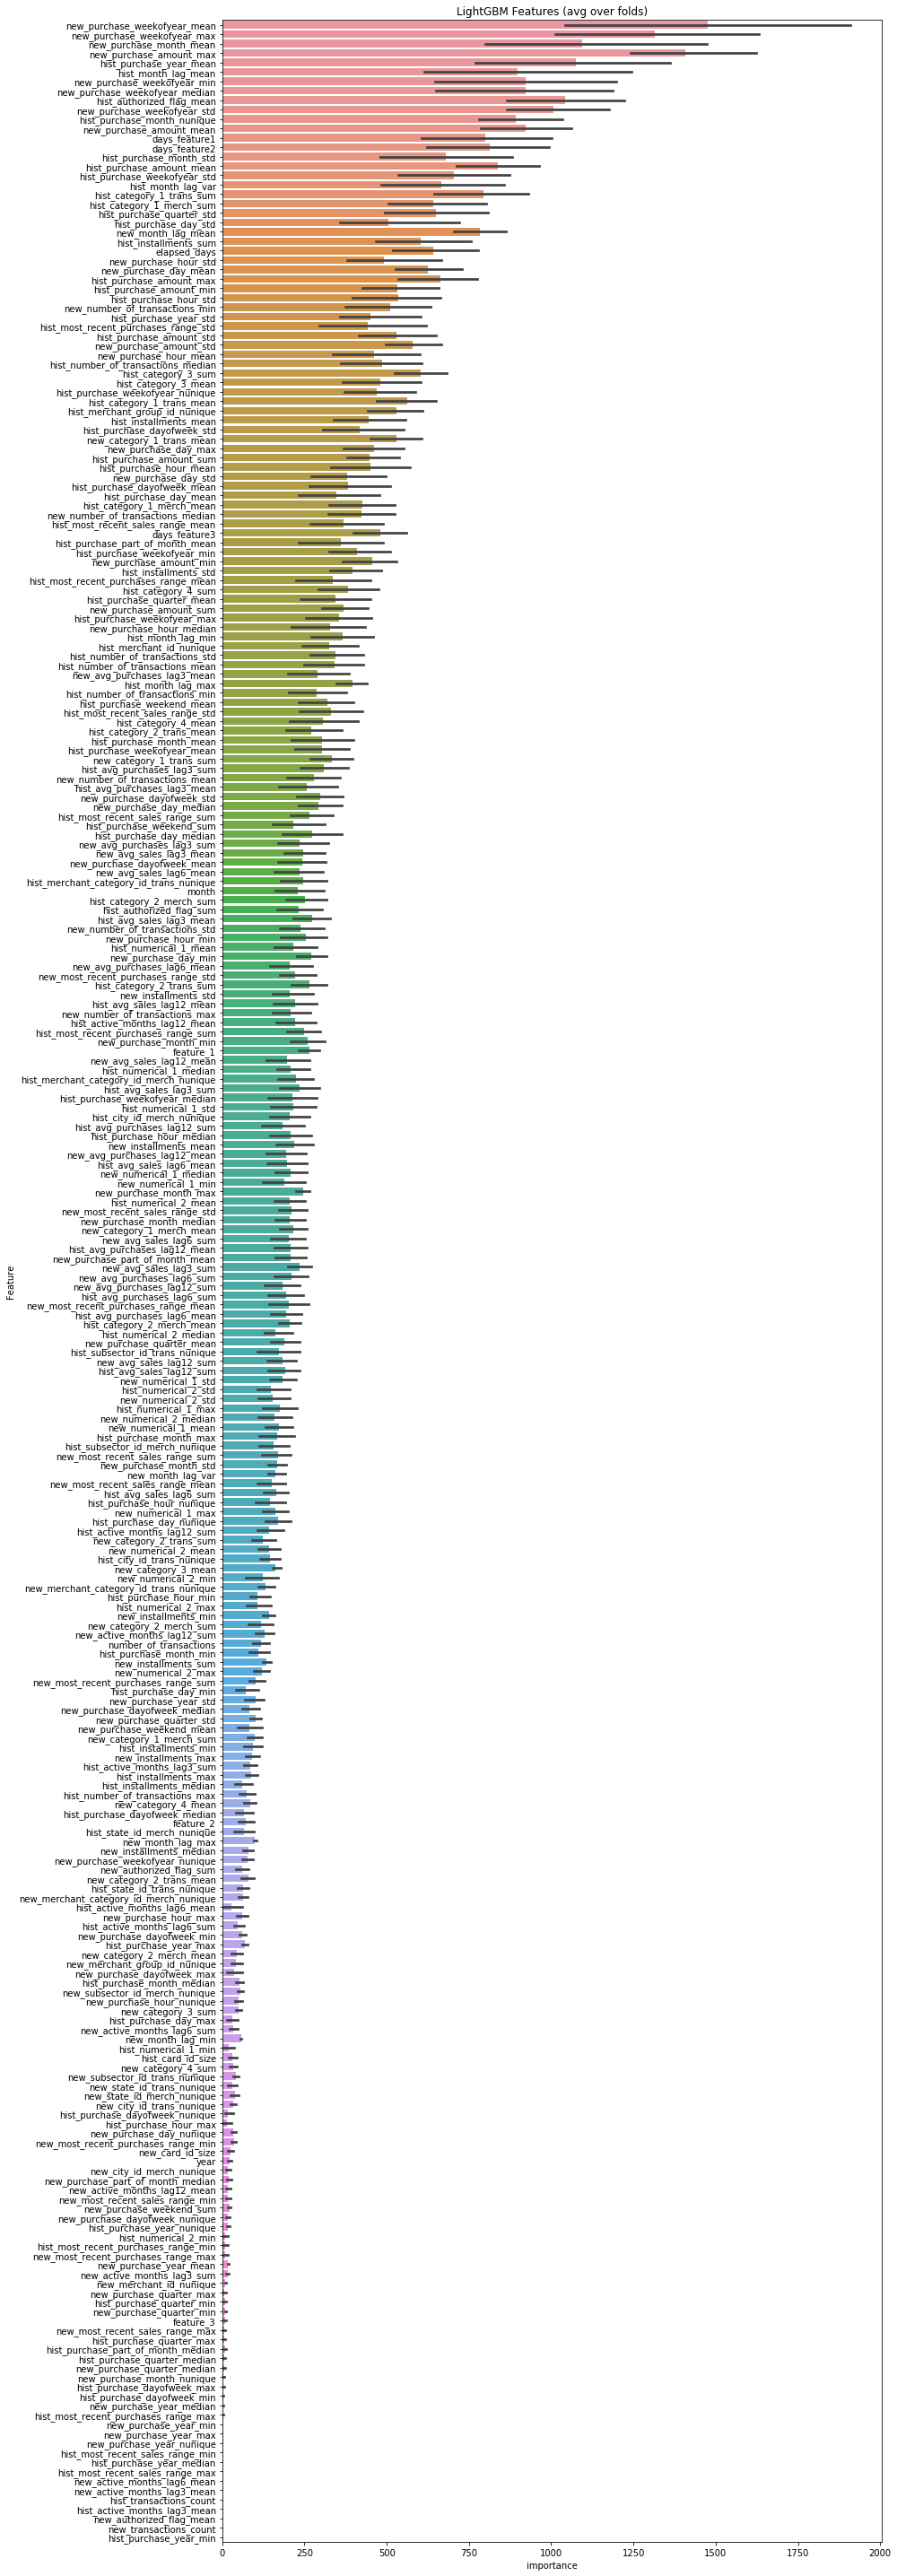

In [72]:
import seaborn as sns

cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14, 40))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [74]:
features = [c for c in df_train.columns if c not in ['target', 'outliers']]

In [ ]:
folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4950)
oof_2 = np.zeros(len(df_train))
predictions_2 = np.zeros(len(df_test))
feature_importance_df_2 = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, df_target.values)):
    
    print("Fold {}.".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][features], label=df_target.iloc[trn_idx])
    val_data = lgb.Dataset(df_train.iloc[val_idx][features], label=df_target.iloc[val_idx])
    
    param ={
        'bagging_seed': int(2**fold_),
        'boosting': 'goss',
        'colsample_bytree': 0.5665320670155495,
        'drop_seed': int(2**fold_),
        'learning_rate': 0.01,
        'max_depth': 7,
        'metric': 'rmse',
        'min_child_weight': 41.9612869171337,
        'min_data_in_leaf': 21,
        'min_split_gain': 9.820197773625843,
        'num_leaves': 63,
        'objective': 'regression',
        'other_rate': 0.0721768246018207,
        'reg_alpha': 9.677537745007898,
        'reg_lambda': 8.2532317400459,
        'seed': int(2**fold_),
        'subsample': 0.9855232997390695,
        'task': 'train',
        'top_rate': 0.9064148448434349,
        'verbose': -1
    }
        
    num_round = 10000
    clf_r = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=-1, early_stopping_rounds = 200)
    oof_2[val_idx] = clf_r.predict(df_train.iloc[val_idx][features], num_iteration=clf_r.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf_r.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df_2 = pd.concat([feature_importance_df_2, fold_importance_df], axis=0)
    
    predictions_2 += clf_r.predict(df_test[features], num_iteration=clf_r.best_iteration) / (5 * 2)

Fold 0.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1146]	training's rmse: 3.3552	valid_1's rmse: 3.65993
Fold 1.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1045]	training's rmse: 3.33615	valid_1's rmse: 3.81103
Fold 2.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[791]	training's rmse: 3.43864	valid_1's rmse: 3.57489
Fold 3.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[899]	training's rmse: 3.40347	valid_1's rmse: 3.62434
Fold 4.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1092]	training's rmse: 3.37868	valid_1's rmse: 3.6231
Fold 5.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[994]	training's rmse: 3.36588	valid_1's rmse: 3.74707
Fold 6.
Training until validation

In [ ]:
print("CV score: {:<8.5f}".format(mean_squared_error(oof_2, df_target)**0.5))

In [ ]:
cols = (feature_importance_df_2[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df_2.loc[feature_importance_df_2.Feature.isin(cols)]

plt.figure(figsize=(14, 40))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [ ]:
from sklearn.linear_model import BayesianRidge

train_stack = np.vstack([oof, oof_2]).transpose()
test_stack = np.vstack([predictions, predictions_2]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=1, random_state=4590)
oof_stack = np.zeros(train_stack.shape[0])
predictions_3 = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):
    print("Fold {}.".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], df_target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], df_target.iloc[val_idx].values

    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)

    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions_3 += clf_3.predict(test_stack) / 5

In [ ]:
pred_3_cv = np.sqrt(mean_squared_error(df_target.values, oof_stack))

In [ ]:
df_sub = pd.DataFrame({"card_id":df_test["card_id"].values})
df_sub["target"] = predictions_3
df_sub.to_csv("output/lgbm_{}.csv".format(pred_3_cv), index=False)

## Feature selection

In [ ]:
cols = ['feature_1', 'feature_2', 'feature_3', 'year', 'month', 'number_of_transactions', 'hist_transactions_count', 'hist_authorized_flag_sum', 'hist_authorized_flag_mean', 'hist_active_months_lag3_sum', 'hist_active_months_lag3_mean', 'hist_active_months_lag6_sum', 'hist_active_months_lag6_mean', 'hist_active_months_lag12_sum', 'hist_active_months_lag12_mean', 'hist_avg_sales_lag3_sum', 'hist_avg_sales_lag3_mean', 'hist_avg_sales_lag6_sum', 'hist_avg_sales_lag6_mean', 'hist_avg_sales_lag12_sum', 'hist_avg_sales_lag12_mean', 'hist_avg_purchases_lag3_sum', 'hist_avg_purchases_lag3_mean', 'hist_avg_purchases_lag6_sum', 'hist_avg_purchases_lag6_mean', 'hist_avg_purchases_lag12_sum', 'hist_avg_purchases_lag12_mean', 'hist_category_1_trans_sum', 'hist_category_1_trans_mean', 'hist_category_1_merch_sum', 'hist_category_1_merch_mean', 'hist_category_2_trans_sum', 'hist_category_2_trans_mean', 'hist_category_2_merch_sum', 'hist_category_2_merch_mean', 'hist_category_3_sum', 'hist_category_3_mean', 'hist_category_4_sum', 'hist_category_4_mean', 'hist_city_id_trans_nunique', 'hist_city_id_merch_nunique', 'hist_installments_sum', 'hist_installments_median', 'hist_installments_mean', 'hist_installments_max', 'hist_installments_min', 'hist_installments_std', 'hist_merchant_id_nunique', 'hist_merchant_category_id_trans_nunique', 'hist_merchant_category_id_merch_nunique', 'hist_merchant_group_id_nunique', 'hist_month_lag_min', 'hist_month_lag_max', 'hist_month_lag_mean', 'hist_most_recent_sales_range_sum', 'hist_most_recent_sales_range_mean', 'hist_most_recent_sales_range_max', 'hist_most_recent_sales_range_min', 'hist_most_recent_sales_range_std', 'hist_most_recent_purchases_range_sum', 'hist_most_recent_purchases_range_mean', 'hist_most_recent_purchases_range_max', 'hist_most_recent_purchases_range_min', 'hist_most_recent_purchases_range_std', 'hist_numerical_1_mean', 'hist_numerical_1_median', 'hist_numerical_1_max', 'hist_numerical_1_min', 'hist_numerical_1_std', 'hist_numerical_2_mean', 'hist_numerical_2_median', 'hist_numerical_2_max', 'hist_numerical_2_min', 'hist_numerical_2_std', 'hist_number_of_transactions_mean', 'hist_number_of_transactions_median', 'hist_number_of_transactions_max', 'hist_number_of_transactions_min', 'hist_number_of_transactions_std', 'hist_state_id_trans_nunique', 'hist_state_id_merch_nunique', 'hist_subsector_id_trans_nunique', 'hist_subsector_id_merch_nunique', 'hist_purchase_amount_sum', 'hist_purchase_amount_mean', 'hist_purchase_amount_max', 'hist_purchase_amount_min', 'hist_purchase_amount_std', 'hist_purchase_year_mean', 'hist_purchase_year_median', 'hist_purchase_year_max', 'hist_purchase_year_min', 'hist_purchase_year_std', 'hist_purchase_month_mean', 'hist_purchase_month_median', 'hist_purchase_month_max', 'hist_purchase_month_min', 'hist_purchase_month_std', 'hist_purchase_day_mean', 'hist_purchase_day_median', 'hist_purchase_day_max', 'hist_purchase_day_min', 'hist_purchase_day_std', 'hist_purchase_hour_mean', 'hist_purchase_hour_median', 'hist_purchase_hour_max', 'hist_purchase_hour_min', 'hist_purchase_hour_std', 'hist_purchase_weekofyear_mean', 'hist_purchase_weekofyear_median', 'hist_purchase_weekofyear_max', 'hist_purchase_weekofyear_min', 'hist_purchase_weekofyear_std', 'hist_purchase_dayofweek_mean', 'hist_purchase_dayofweek_median', 'hist_purchase_dayofweek_max', 'hist_purchase_dayofweek_min', 'hist_purchase_dayofweek_std', 'hist_purchase_quarter_mean', 'hist_purchase_quarter_median', 'hist_purchase_quarter_max', 'hist_purchase_quarter_min', 'hist_purchase_quarter_std', 'hist_purchase_part_of_month_mean', 'hist_purchase_part_of_month_median', 'new_transactions_count', 'new_authorized_flag_sum', 'new_authorized_flag_mean', 'new_active_months_lag3_sum', 'new_active_months_lag3_mean', 'new_active_months_lag6_sum', 'new_active_months_lag6_mean', 'new_active_months_lag12_sum', 'new_active_months_lag12_mean', 'new_avg_sales_lag3_sum', 'new_avg_sales_lag3_mean', 'new_avg_sales_lag6_sum', 'new_avg_sales_lag6_mean', 'new_avg_sales_lag12_sum', 'new_avg_sales_lag12_mean', 'new_avg_purchases_lag3_sum', 'new_avg_purchases_lag3_mean', 'new_avg_purchases_lag6_sum', 'new_avg_purchases_lag6_mean', 'new_avg_purchases_lag12_sum', 'new_avg_purchases_lag12_mean', 'new_category_1_trans_sum', 'new_category_1_trans_mean', 'new_category_1_merch_sum', 'new_category_1_merch_mean', 'new_category_2_trans_sum', 'new_category_2_trans_mean', 'new_category_2_merch_sum', 'new_category_2_merch_mean', 'new_category_3_sum', 'new_category_3_mean', 'new_category_4_sum', 'new_category_4_mean', 'new_city_id_trans_nunique', 'new_city_id_merch_nunique', 'new_installments_sum', 'new_installments_median', 'new_installments_mean', 'new_installments_max', 'new_installments_min', 'new_installments_std', 'new_merchant_id_nunique', 'new_merchant_category_id_trans_nunique', 'new_merchant_category_id_merch_nunique', 'new_merchant_group_id_nunique', 'new_month_lag_min', 'new_month_lag_max', 'new_month_lag_mean', 'new_most_recent_sales_range_sum', 'new_most_recent_sales_range_mean', 'new_most_recent_sales_range_max', 'new_most_recent_sales_range_min', 'new_most_recent_sales_range_std', 'new_most_recent_purchases_range_sum', 'new_most_recent_purchases_range_mean', 'new_most_recent_purchases_range_max', 'new_most_recent_purchases_range_min', 'new_most_recent_purchases_range_std', 'new_numerical_1_mean', 'new_numerical_1_median', 'new_numerical_1_max', 'new_numerical_1_min', 'new_numerical_1_std', 'new_numerical_2_mean', 'new_numerical_2_median', 'new_numerical_2_max', 'new_numerical_2_min', 'new_numerical_2_std', 'new_number_of_transactions_mean', 'new_number_of_transactions_median', 'new_number_of_transactions_max', 'new_number_of_transactions_min', 'new_number_of_transactions_std', 'new_state_id_trans_nunique', 'new_state_id_merch_nunique', 'new_subsector_id_trans_nunique', 'new_subsector_id_merch_nunique', 'new_purchase_amount_sum', 'new_purchase_amount_mean', 'new_purchase_amount_max', 'new_purchase_amount_min', 'new_purchase_amount_std', 'new_purchase_year_mean', 'new_purchase_year_median', 'new_purchase_year_max', 'new_purchase_year_min', 'new_purchase_year_std', 'new_purchase_month_mean', 'new_purchase_month_median', 'new_purchase_month_max', 'new_purchase_month_min', 'new_purchase_month_std', 'new_purchase_day_mean', 'new_purchase_day_median', 'new_purchase_day_max', 'new_purchase_day_min', 'new_purchase_day_std', 'new_purchase_hour_mean', 'new_purchase_hour_median', 'new_purchase_hour_max', 'new_purchase_hour_min', 'new_purchase_hour_std', 'new_purchase_weekofyear_mean', 'new_purchase_weekofyear_median', 'new_purchase_weekofyear_max', 'new_purchase_weekofyear_min', 'new_purchase_weekofyear_std', 'new_purchase_dayofweek_mean', 'new_purchase_dayofweek_median', 'new_purchase_dayofweek_max', 'new_purchase_dayofweek_min', 'new_purchase_dayofweek_std', 'new_purchase_quarter_mean', 'new_purchase_quarter_median', 'new_purchase_quarter_max', 'new_purchase_quarter_min', 'new_purchase_quarter_std', 'new_purchase_part_of_month_mean', 'new_purchase_part_of_month_median']
X = df_train[cols].copy()
y = df_train.target

In [ ]:
X.columns.tolist()

### 6 Ways for Feature Selection
https://www.kaggle.com/sz8416/6-ways-for-feature-selection

#### Pearson correlation

In [ ]:
def cor_selector(X, y, limit=500):
    cor_list = []
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)

    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-limit:]].columns.tolist()
    cor_support = [True if i in cor_feature else False for i in X.columns.tolist()]
    return cor_support, cor_feature, cor_list

In [ ]:
cor_support, cor_feature, cor_value = cor_selector(X, y)
print(str(len(cor_feature)), 'selected features')

In [ ]:
df_c_supp = pd.DataFrame(data={
    'variable_name': cor_feature,
    'corr_coeff': cor_value
})

df_c_supp.sort_values('corr_coeff', axis=0, inplace=True, ascending=False)

In [ ]:
df_c_supp[:5]

In [ ]:
df_c_supp.plot.bar(x='variable_name', y='corr_coeff', rot=60, figsize=(50, 5))

In [ ]:
cols_2_use = df_c_supp[df_c_supp['corr_coeff'] > 0]['variable_name']
len(df_c_supp[df_c_supp['corr_coeff'] > 0])

In [ ]:
list(cols_2_use)